# Exercises

Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

Bonus:

Can you label students who are viewing both the web dev and data science curriculum? Can you label students by the program they are in? Can you label users by student vs. staff? What are Zach, Maggie, Faith, and Ryan's ids?

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

---
## Wrangle

In [2]:
df = pd.read_csv('anonymized-curriculum-access.txt', sep=' ', parse_dates=True, names=['date', 'time', 'path', 'user_id', 'cohort_id', 'ip'])
df['date'] = df['date'].map(str) + ' ' + df['time'].map(str) 
df = df.drop(columns='time')

In [3]:
df['date'] = pd.to_datetime(df.date)
df = df.set_index('date').sort_index()

In [4]:
df.dtypes

path          object
user_id        int64
cohort_id    float64
ip            object
dtype: object

In [5]:
df.nunique()

path         2153
user_id       787
cohort_id      40
ip           4339
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719459 entries, 2018-01-26 09:55:03 to 2020-11-02 16:48:47
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   path       719458 non-null  object 
 1   user_id    719459 non-null  int64  
 2   cohort_id  674619 non-null  float64
 3   ip         719459 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 27.4+ MB


In [7]:
df.head(10)

,path,user_id,cohort_id,ip
date,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61
2018-01-26 09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61
2018-01-26 09:56:48,javascript-i/functions,3,22.0,97.105.19.61
2018-01-26 09:56:59,javascript-i/loops,2,22.0,97.105.19.61


---
## Explore

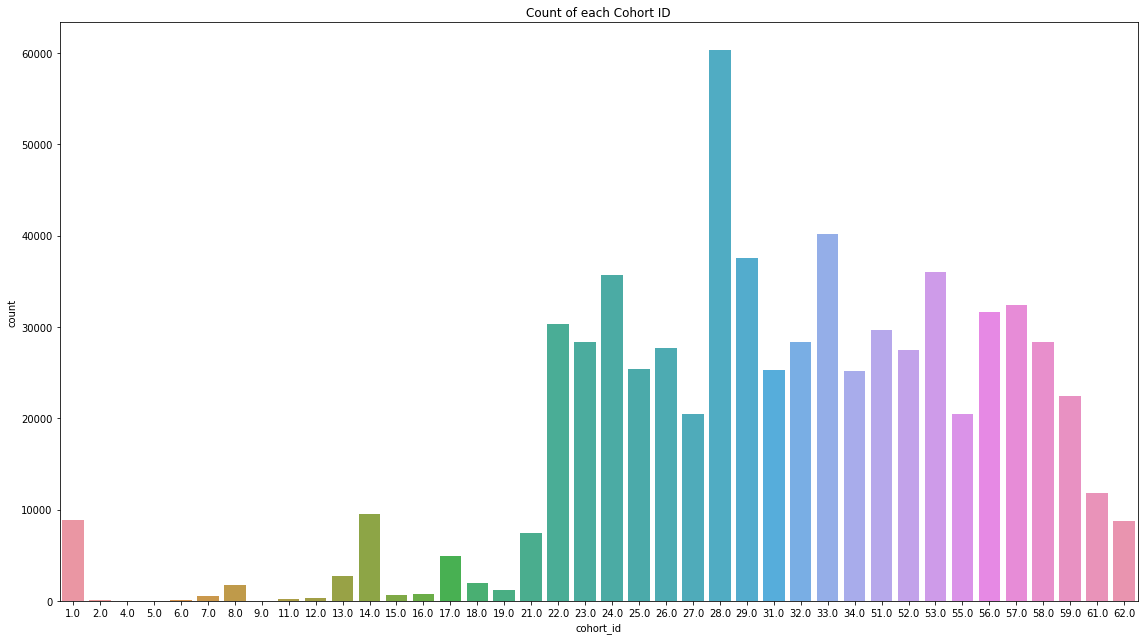

In [8]:
# count plot of each cohort id
plt.figure(figsize=(16,9))
sns.countplot(x=df.cohort_id)
plt.title('Count of each Cohort ID')
plt.tight_layout()

In [9]:
# start and end dates
df.index.min(), df.index.max()

(Timestamp('2018-01-26 09:55:03'), Timestamp('2020-11-02 16:48:47'))

<Figure size 1152x648 with 0 Axes>

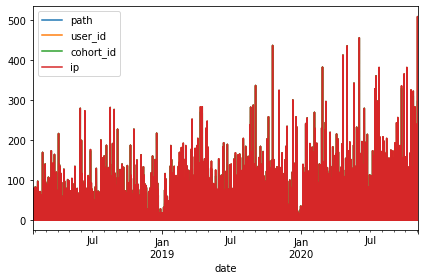

In [10]:
# resample by 30 min increments and group by count since each column is categorical
plt.figure(figsize=(16,9))
df.resample('30T').count().plot()
plt.tight_layout()

In [11]:
df = df.dropna()

In [12]:
df.isna().sum()

path         0
user_id      0
cohort_id    0
ip           0
dtype: int64

In [13]:
df

,path,user_id,cohort_id,ip
date,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...
2020-11-02 16:48:13,javascript-i/coffee-project,763,62.0,107.192.148.199
2020-11-02 16:48:17,javascript-i/mapbox-api,771,62.0,172.125.226.175
2020-11-02 16:48:18,javascript-i/coffee-project,771,62.0,172.125.226.175


### Split Data

In [99]:
train = df[:'2019-12-31']
validate = df['2020-01-01':'2020-06-30']
test = df['2020-07-01':]
print('train      ', 'validate     ', 'test')
print(train.shape, validate.shape, test.shape)
round(train.shape[0]/len(df),2), round(validate.shape[0]/len(df),2), round(test.shape[0]/len(df), 2)

train       validate      test
(394751, 4) (164043, 4) (115824, 4)


(0.59, 0.24, 0.17)

Number of pages accessed per day - select one cohort (look at a spike)
Day of the week, day, hour
What should we measure?
Generate count for pages/path
total number of events, distinct pages

In [25]:
df.dtypes

path          object
user_id        int64
cohort_id    float64
ip            object
dtype: object

### Darden's Anomalous Duo

In [39]:
# darden cohort
darden = df[df.cohort_id == 59.0]
darden

,path,user_id,cohort_id,ip
date,,,,
2020-07-13 14:34:44,/,678,59.0,76.201.20.193
2020-07-13 14:37:22,/,679,59.0,24.28.146.155
2020-07-13 14:38:28,/,680,59.0,136.50.56.155
2020-07-13 14:39:21,13-advanced-topics/1-tidy-data,679,59.0,24.28.146.155
2020-07-13 14:39:36,1-fundamentals/1.1-intro-to-data-science,679,59.0,24.28.146.155
...,...,...,...,...
2020-11-02 15:47:59,appendix/useful_libraries,698,59.0,24.28.150.196
2020-11-02 15:48:03,appendix/ds-environment-setup,698,59.0,24.28.150.196
2020-11-02 15:48:14,appendix/interview_questions_students,698,59.0,24.28.150.196


In [43]:
# 21 initial darden students, 5 instructors, there are 2 who are not in class???
darden.user_id.nunique()

28

In [46]:
# perhaps the 2 'weirdos' are 679 and 697?
# observations for each user
darden.groupby('user_id').size().sort_values()

user_id
679      11
697      13
785      31
780      52
783      54
781      94
683     168
693     429
739     522
694     567
690     663
695     702
686     725
687     732
268     781
680     847
684     853
696     858
678     937
682    1184
691    1222
688    1248
692    1261
681    1270
699    1420
689    1544
698    1695
685    2542
dtype: int64

In [52]:
# the 2 weirdos are up again for using the curriculmn the least.
# number of different pages that were accessed by each user
darden.groupby('user_id').path.nunique().sort_values()

user_id
679      5
697     10
783     13
785     14
781     21
780     24
683     47
739     76
693    109
686    127
694    132
690    132
678    134
688    141
687    147
695    147
696    148
691    155
684    155
681    156
680    158
689    159
682    160
268    169
692    179
685    188
699    194
698    214
Name: path, dtype: int64

In [54]:
# what does the activity of the weirdos look like?
# they only accessed the curriculmn on day 1 and 2
df[(df.user_id == 697) | (df.user_id == 679)]

,path,user_id,cohort_id,ip
date,,,,
2020-07-13 14:37:22,/,679,59.0,24.28.146.155
2020-07-13 14:39:21,13-advanced-topics/1-tidy-data,679,59.0,24.28.146.155
2020-07-13 14:39:36,1-fundamentals/1.1-intro-to-data-science,679,59.0,24.28.146.155
2020-07-13 14:39:37,1-fundamentals/AI-ML-DL-timeline.jpg,679,59.0,24.28.146.155
2020-07-13 14:39:37,1-fundamentals/modern-data-scientist.jpg,679,59.0,24.28.146.155
2020-07-13 15:20:27,/,697,59.0,136.50.70.27
2020-07-13 15:20:48,3-sql/1-mysql-overview,697,59.0,136.50.70.27
2020-07-13 15:20:50,1-fundamentals/1.1-intro-to-data-science,697,59.0,136.50.70.27
2020-07-13 15:20:50,1-fundamentals/modern-data-scientist.jpg,697,59.0,136.50.70.27


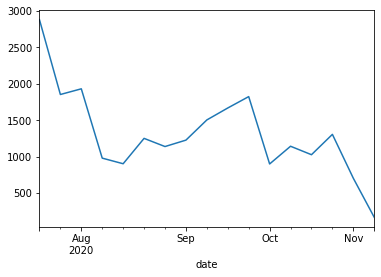

In [71]:
darden.resample('w').size().plot()

In [73]:
# hey its ME!
darden[darden.ip == '67.11.40.170']

,path,user_id,cohort_id,ip
date,,,,
2020-07-13 14:43:14,/,690,59.0,67.11.40.170
2020-07-15 08:39:29,1-fundamentals/1.1-intro-to-data-science,690,59.0,67.11.40.170
2020-07-15 08:39:29,1-fundamentals/modern-data-scientist.jpg,690,59.0,67.11.40.170
2020-07-15 08:39:30,1-fundamentals/AI-ML-DL-timeline.jpg,690,59.0,67.11.40.170
2020-07-15 08:53:08,1-fundamentals/1.1-intro-to-data-science,690,59.0,67.11.40.170
...,...,...,...,...
2020-10-30 09:44:56,timeseries/modeling-lesson1,690,59.0,67.11.40.170
2020-11-02 10:12:06,/,690,59.0,67.11.40.170
2020-11-02 12:03:02,timeseries/explore,690,59.0,67.11.40.170


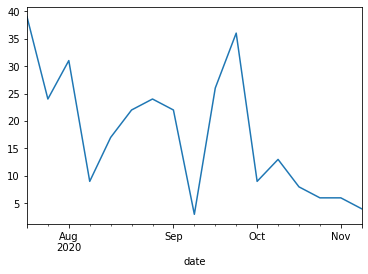

In [77]:
darden[darden.ip == '67.11.40.170'].resample('w').size().plot()

In [79]:
darden[darden.user_id == 685]

,path,user_id,cohort_id,ip
date,,,,
2020-07-13 14:40:31,/,685,59.0,99.76.233.212
2020-07-13 23:23:10,/,685,59.0,99.76.233.212
2020-07-14 08:30:16,/,685,59.0,99.76.233.212
2020-07-14 10:37:01,/,685,59.0,99.76.233.212
2020-07-14 11:09:36,1-fundamentals/1.1-intro-to-data-science,685,59.0,99.76.233.212
...,...,...,...,...
2020-11-02 15:20:36,timeseries/modeling-lesson1,685,59.0,99.76.233.212
2020-11-02 15:20:50,timeseries/modeling-lesson1,685,59.0,99.76.233.212
2020-11-02 15:42:31,classification/overview,685,59.0,99.76.233.212


### Exponential Moving Average